1. Project Goal: Using SP500 time series data to predict price movement

2. Gathering data

In [55]:
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import xgboost as xgb
import pandas as pd 

In [56]:
def get_data(_ticker, _period):
    sp500 = yf.Ticker(_ticker).history(period=_period)
    return sp500

In [57]:
sp500 = get_data("^GSPC", "max")

<AxesSubplot:xlabel='Date'>

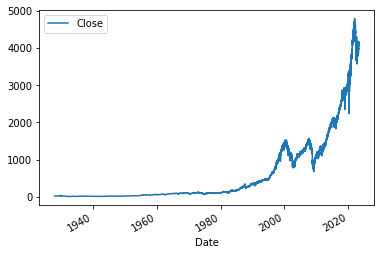

In [58]:
# Visualise data
sp500.plot.line(y = "Close", use_index=True)

3. Data Preprocessing

In [59]:
def delete_columns(df, cols_list):
    df_out = df.drop(cols_list, axis=1)
    return df_out

# let's remove "Dividends" and "Stock Splits" columns as they are not relevant for our analysis at this time

cols_to_be_removed = ["Dividends", "Stock Splits"]

sp500_2 = delete_columns(sp500, cols_to_be_removed)
sp500_2

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2023-05-02 00:00:00-04:00,4164.100098,4164.100098,4089.719971,4119.580078,4486130000
2023-05-03 00:00:00-04:00,4122.250000,4148.299805,4088.860107,4090.750000,4246510000
2023-05-04 00:00:00-04:00,4082.550049,4082.610107,4048.280029,4061.219971,4920090000


4. Feature engineering: Create additional features from the existing data that can improve the model's predictive power.

In [60]:
# shifting and copying next day price into a new column "NextDayPrice"
sp500_2["NextDayPrice"] = sp500_2["Close"].shift(-1)

In [61]:
# 1 => price went up, 0 => price went down
sp500_2["Direction"] = (sp500_2["NextDayPrice"] > sp500_2["Close"]).astype(int)

In [62]:
# To account for significant market shifts, let's limit the data from 1990 onwards

sp500_3 = sp500_2.loc["1990-01-01":].copy()

In [63]:
# Adding more features. Rolling averages
def add_rolling_avg_features(df, time_frames):
    predictors = []
    for time_frame in time_frames:
        rolling_averages = df.rolling(time_frame).mean()
        ratio_column = f"Close_Ratio_{time_frame}"
        df[ratio_column] = df["Close"] / rolling_averages["Close"]
        predictors.append(ratio_column)
    return [df, predictors]

# [last 2 days, last week, last 3 months(quarter), last year, last 4 years]
time_frames = [2,5,60,250,1000]
output = add_rolling_avg_features(sp500_3, time_frames)
sp500_4 = output[0]
predictors = output[1]
sp500_4

,Open,High,Low,Close,Volume,NextDayPrice,Direction,Close_Ratio_2,Close_Ratio_5,Close_Ratio_60,Close_Ratio_250,Close_Ratio_1000
Date,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,0.993731,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-02 00:00:00-04:00,4164.100098,4164.100098,4089.719971,4119.580078,4486130000,4090.750000,0,0.994173,0.997561,1.017386,1.039867,1.102820
2023-05-03 00:00:00-04:00,4122.250000,4148.299805,4088.860107,4090.750000,4246510000,4061.219971,0,0.996489,0.988915,1.010351,1.032808,1.094734
2023-05-04 00:00:00-04:00,4082.550049,4082.610107,4048.280029,4061.219971,4920090000,4136.250000,1,0.996378,0.985307,1.003482,1.025441,1.086480


In [64]:
# Null removal
sp500_5 = sp500_4.dropna()

5. Selecting a Model

Models of choice: Random Forrest Classifier and XG Boost

In [94]:
rfc_model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
xgb_model = xgb.XGBClassifier(n_estimators=100)

# separating the dataset into training and testing sets. 
train = sp500_5.iloc[:-100] # all rows except the last 100 rows
test = sp500_5.iloc[-100:] # the last 100 rows



In [95]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Direction"])
    # if model_type == "rfc":
    if model == rfc_model:
        predictions = model.predict_proba(test[predictors])[:,1] # the model predicts the probably of the market moving up or down
    else:
        predictions = model.predict(test[predictors])
    predictions[predictions >= 0.6] = 1 # we want to create a more confident model so if we have a probability > 0.6, we consider that as probable
    predictions[predictions < 0.6] = 0 # probability <= 0.6 will be considered as improbable which means we cannot confidently say the market is going up so we will just consider it as a downward movement
    predictions = pd.Series(predictions, index=test.index, name="Predictions")
    combined_df = pd.concat([test["Direction"], predictions], axis=1)
    return combined_df

In [96]:

rfc_pred_df = predict(train, test, predictors, rfc_model)
xgb_pred_df = predict(train, test, predictors, xgb_model)

In [97]:
xgb_pred_df

,Direction,Predictions
Date,,
2022-12-12 00:00:00-05:00,1,0
2022-12-13 00:00:00-05:00,0,0
2022-12-14 00:00:00-05:00,0,1
2022-12-15 00:00:00-05:00,0,0
2022-12-16 00:00:00-05:00,0,0
...,...,...
2023-05-01 00:00:00-04:00,0,1
2023-05-02 00:00:00-04:00,0,1
2023-05-03 00:00:00-04:00,0,1


In [98]:
# backtesting models
def backtest(data, model, predictors, start=2500, step=250):
    # every trading year has 250 days. So we're taking 10 years of data to train the model
    # we take the first 10 years of data to predict value for the 11th year and so on.
    # step=250 because every trading year has 250 days. Prediction runs for every year from the first 10 years onwards
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
        # print(predictions)
    return pd.concat(all_predictions)

In [99]:
rfc_pred = backtest(sp500_5, rfc_model, predictors)
rfc_pred

,Direction,Predictions
Date,,
2003-11-13 00:00:00-05:00,0,0.0
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,0.0
2003-11-18 00:00:00-05:00,1,0.0
2003-11-19 00:00:00-05:00,0,0.0
...,...,...
2023-05-01 00:00:00-04:00,0,1.0
2023-05-02 00:00:00-04:00,0,0.0
2023-05-03 00:00:00-04:00,0,1.0


In [100]:
rfc_score = precision_score(rfc_pred["Direction"], rfc_pred["Predictions"])
rfc_score

0.5808457711442786

In [101]:
xgb_pred = backtest(sp500_5, xgb_model, predictors)
xgb_score = precision_score(xgb_pred["Direction"], xgb_pred["Predictions"])
xgb_score

0.5576857240671003